# 1.	Import Dataset


### Read dataset from raw CSV.

In [3]:
import pandas as pd
import numpy as np

# Read sampled data
df_accepted = pd.read_csv("accepted_2007_to_2018Q4.csv.gz", compression="gzip", nrows=50000)
df_rejected = pd.read_csv("rejected_2007_to_2018Q4.csv.gz", compression="gzip", nrows=50000)


/var/folders/b2/s6cq43q964gcjk0fp440gx_h0000gn/T/ipykernel_1182/1816537402.py:5: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accepted = pd.read_csv("accepted_2007_to_2018Q4.csv.gz", compression="gzip", nrows=50000)


# Step 2: Cleaning
### 2.1 Accepted Loans

Handle missing values (impute emp_length, drop irrelevant columns)

Encode categorical features

Normalize numeric features

In [5]:
relevant_cols = [
    "loan_amnt",        # Amount Requested
    "issue_d",          # Application Date
    "purpose",          # Loan Title
    "dti",              # Debt-To-Income Ratio
    "addr_state",       # State
    "emp_length"        # Employment Length
]

df_accepted_reduced = df_accepted[relevant_cols].copy()
print(df_accepted_reduced.head())

   loan_amnt   issue_d             purpose    dti addr_state emp_length
0     3600.0  Dec-2015  debt_consolidation   5.91         PA  10+ years
1    24700.0  Dec-2015      small_business  16.06         SD  10+ years
2    20000.0  Dec-2015    home_improvement  10.78         IL  10+ years
3    35000.0  Dec-2015  debt_consolidation  17.06         NJ  10+ years
4    10400.0  Dec-2015      major_purchase  25.37         PA    3 years


In [6]:
accepted_clean = df_accepted_reduced.copy()

# Drop irrelevant columns
accepted_clean = accepted_clean.drop(columns=['issue_d'])  # keep is_default as target

def clean_emp_length(x):
    if pd.isna(x):
        return np.nan
    x = x.strip()
    if x == '< 1 year':
        return 0
    elif x == '10+ years':
        return 10
    else:
        return int(x.split()[0])  # e.g., '4 years' -> 4

# Apply to accepted dataset
accepted_clean['emp_length'] = accepted_clean['emp_length'].apply(clean_emp_length)


In [7]:
# Fill missing emp_length with median
accepted_clean['emp_length'] = accepted_clean['emp_length'].fillna(accepted_clean['emp_length'].median())

In [8]:
accepted_clean["accepted"] = 1

In [9]:
accepted_clean.head(3)

,loan_amnt,purpose,dti,addr_state,emp_length,accepted
0,3600.0,debt_consolidation,5.91,PA,10.0,1
1,24700.0,small_business,16.06,SD,10.0,1
2,20000.0,home_improvement,10.78,IL,10.0,1


### 2.2 Rejected Loans

Drop irrelevant/missing columns

Encode categorical features same way as accepted loans

Assign target is_default = 0 (they never got a loan, so assume no default for modeling)

In [11]:
print(df_rejected.columns)

Index(['Amount Requested', 'Application Date', 'Loan Title', 'Risk_Score',
       'Debt-To-Income Ratio', 'Zip Code', 'State', 'Employment Length',
       'Policy Code'],
      dtype='object')


In [12]:
rejected_clean = df_rejected.copy()
rejected_clean = rejected_clean.drop(columns=['Policy Code','Risk_Score','Zip Code'])


In [13]:
rejected_clean = rejected_clean.rename(columns={
    'Amount Requested': 'loan_amnt',
    'Application Date': 'issue_d',
    'Loan Title': 'purpose',
    'Debt-To-Income Ratio': 'dti',
    'State': 'addr_state',
    'Employment Length': 'emp_length'
})

In [14]:
print(rejected_clean.columns)

Index(['loan_amnt', 'issue_d', 'purpose', 'dti', 'addr_state', 'emp_length'], dtype='object')


In [15]:
# Drop rows with missing values
rejected_clean = rejected_clean.dropna()

In [16]:
# Apply to accepted dataset
rejected_clean['emp_length'] = rejected_clean['emp_length'].apply(clean_emp_length)

In [17]:
# Remove '%' and convert to float
rejected_clean['dti'] = (
    rejected_clean['dti']
    .str.replace('%', '', regex=False)  # remove %
    .astype(float)                      # convert to float
)


In [18]:
# Add target column
rejected_clean['accepted'] = 0

In [19]:
rejected_clean.head(3)

,loan_amnt,issue_d,purpose,dti,addr_state,emp_length,accepted
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,10.0,NM,4,0
1,1000.0,2007-05-26,Consolidating Debt,10.0,MA,0,0
2,11000.0,2007-05-27,Want to consolidate my debt,10.0,MD,1,0


## 2.3 Align Features

In [21]:
# Align columns
accepted_clean, rejected_clean = accepted_clean.align(rejected_clean, join='outer', axis=1, fill_value=0)

# Combine datasets
df_combined = pd.concat([accepted_clean, rejected_clean], axis=0).reset_index(drop=True)
df_combined.head(3)

,accepted,addr_state,dti,emp_length,issue_d,loan_amnt,purpose
0,1,PA,5.91,10.0,0,3600.0,debt_consolidation
1,1,SD,16.06,10.0,0,24700.0,small_business
2,1,IL,10.78,10.0,0,20000.0,home_improvement


In [22]:
# Number of rows
print("Number of rows in accepted_clean:", accepted_clean.shape[0])
print("Number of rows in rejected_clean:", rejected_clean.shape[0])

# Combine the datasets
df_combined = pd.concat([accepted_clean, rejected_clean], ignore_index=True)

# Number of columns in combined DataFrame
print("Number of columns in df_combined:", df_combined.shape[0])

Number of rows in accepted_clean: 50000
Number of rows in rejected_clean: 49968
Number of columns in df_combined: 99968


In [23]:
# Number of unique purposes
num_unique = df_combined['purpose'].nunique()
print("Number of unique purposes:", num_unique)

# Optional: list of unique purposes
unique_purposes = df_combined['purpose'].unique()
print("Unique purposes:\n", unique_purposes)


Number of unique purposes: 30943
Unique purposes:
 ['debt_consolidation' 'small_business' 'home_improvement' ...
 'Expanding Online Business' 'our family purchase' 'Needing money quick']


## 2.4 Purpouse column NLP

In [25]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from tqdm import tqdm
import openai

In [26]:
# 1) Preprocessing

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = text.replace("_", " ")             # replace underscores with spaces
    text = re.sub(r"[^a-z0-9\s]", " ", text) # remove special characters
    text = re.sub(r"\s+", " ", text).strip() # collapse whitespace
    return text

In [27]:
unique_purposes_clean=[]
for text in unique_purposes:
    unique_purposes_clean.append(preprocess_text(text))



In [28]:
print(unique_purposes_clean[:20])

['debt consolidation', 'small business', 'home improvement', 'major purchase', 'credit card', 'other', 'house', 'vacation', 'car', 'medical', 'moving', 'renewable energy', 'wedding covered but no honeymoon', 'consolidating debt', 'want to consolidate my debt', 'waksman', 'mdrigo', 'trinfiniti', 'notifyi inc', 'for justin']


### 2.4.1 Cluster locally using TFIDF

In [30]:
# Step 1: Vectorize + Cluster
# -----------------------------
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = vectorizer.fit_transform(unique_purposes_clean)

num_clusters = 50  # adjust 50–100 depending on granularity
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# Map each purpose to its cluster
cluster_to_items = {}
for label, purpose in zip(cluster_labels, unique_purposes_clean):
    cluster_to_items.setdefault(label, []).append(purpose)

### 2.4.2 Use Open AI to further cluster

In [32]:
# https://platform.openai.com/api-keys

In [33]:
import openai
import json

openai.api_key = "secret_key"


In [34]:

cluster_to_title = {}

for cluster_id, items in cluster_to_items.items():
    # Take top 10 representative purposes
    top_items = items[:10]
    #print(top_items)

    prompt = f"""
    You are an assistant that groups loan purposes. 
    Given these examples: {top_items}
    Suggest a concise, human-readable category name:
    """

    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",  # or gpt-4o-mini if quota allows
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        title = response.choices[0].message.content.strip()
    except Exception as e:
        # print(f"Error for cluster {cluster_id}: {e}")
        # Fallback to placeholder
        title = f"Category_{cluster_id}"

    cluster_to_title[cluster_id] = title

# Map cluster titles back to purposes
purpose_to_category = {}
for cluster_id, items in cluster_to_items.items():
    title = cluster_to_title[cluster_id]
    for purpose in items:
        purpose_to_category[purpose] = title

# Apply mapping to df_combined
df_combined['purpose_clean'] = df_combined['purpose'].map(preprocess_text)
df_combined['purpose_category'] = df_combined['purpose_clean'].map(purpose_to_category)


used chatGPT to get tiles for each category based on top ten cluster items. because of Rate Limiter error from OpenAI API call.

In [36]:
cluster_to_category = {
    "Category_0": "Debt Consolidation",
    "Category_1": "Business Loans",
    "Category_2": "Home Improvement",
    "Category_3": "Major Purchases",
    "Category_4": "Credit Card Payoff",
    "Category_5": "Miscellaneous",
    "Category_6": "Car Loans",
    "Category_7": "Medical Expenses",
    "Category_8": "Debt Consolidation",
    "Category_9": "Debt Consolidation",
    "Category_10": "Debt Consolidation",
    "Category_11": "Debt Repayment",
    "Category_12": "Education Loans",
    "Category_13": "New Beginnings",
    "Category_14": "Debt Repayment",
    "Category_15": "Education Loans",
    "Category_16": "Personal Loans",
    "Category_17": "Credit Card Payoff",
    "Category_18": "Personal Assistance",
    "Category_19": "Emergency Assistance",
    "Category_20": "Debt Consolidation",
    "Category_21": "High Interest Debt Payoff",
    "Category_22": "Fresh Start / Startup",
    "Category_23": "Emergency Assistance",
    "Category_24": "High Interest Debt Payoff",
    "Category_25": "Credit Card Refinancing",
    "Category_26": "Education Loans",
    "Category_27": "Personal Expenses",
    "Category_28": "Success Stories",
    "Category_29": "Credit Card Payoff",
    "Category_30": "Financial Recovery",
    "Category_31": "School & Bills",
    "Category_32": "Debt Relief",
    "Category_33": "Down Payment",
    "Category_34": "Car Loan",
    "Category_35": "Business Capital",
    "Category_36": "Used Car Loans",
    "Category_37": "Startup Loans",
    "Category_38": "Real Estate Investment",
    "Category_39": "Business Expansion",
    "Category_40": "Credit Card Refinancing",
    "Category_41": "General Loans",
    "Category_42": "Motorcycle Loans",
    "Category_43": "Private Loans",
    "Category_44": "Education / Equipment",
    "Category_45": "Business / Music Loans",
    "Category_46": "Relocation Loans",
    "Category_47": "Personal Assistance",
    "Category_48": "Business Startup",
    "Category_49": "Miscellaneous / Other"
}


In [37]:
df_combined.head(10)

,accepted,addr_state,dti,emp_length,issue_d,loan_amnt,purpose,purpose_clean,purpose_category
0,1,PA,5.91,10.0,0,3600.0,debt_consolidation,debt consolidation,Category_8
1,1,SD,16.06,10.0,0,24700.0,small_business,small business,Category_36
2,1,IL,10.78,10.0,0,20000.0,home_improvement,home improvement,Category_10
3,1,NJ,17.06,10.0,0,35000.0,debt_consolidation,debt consolidation,Category_8
4,1,PA,25.37,3.0,0,10400.0,major_purchase,major purchase,Category_35
5,1,GA,10.20,4.0,0,11950.0,debt_consolidation,debt consolidation,Category_8
6,1,MN,14.67,10.0,0,20000.0,debt_consolidation,debt consolidation,Category_8
7,1,SC,17.61,10.0,0,20000.0,major_purchase,major purchase,Category_35
8,1,PA,13.07,6.0,0,10000.0,credit_card,credit card,Category_0
9,1,RI,34.80,10.0,0,8000.0,credit_card,credit card,Category_0


In [38]:
# Map purpose_category to human-readable loan purpose
df_combined['loan_purpose'] = df_combined['purpose_category'].map(cluster_to_category)

# Optional: keep only relevant columns
df_combined = df_combined[['accepted', 'addr_state', 'dti', 'emp_length', 'issue_d', 'loan_amnt', 'loan_purpose']]

# Display
print(df_combined.head())

   accepted addr_state    dti  emp_length issue_d  loan_amnt  \
0         1         PA   5.91        10.0       0     3600.0   
1         1         SD  16.06        10.0       0    24700.0   
2         1         IL  10.78        10.0       0    20000.0   
3         1         NJ  17.06        10.0       0    35000.0   
4         1         PA  25.37         3.0       0    10400.0   

         loan_purpose  
0  Debt Consolidation  
1      Used Car Loans  
2  Debt Consolidation  
3  Debt Consolidation  
4    Business Capital  


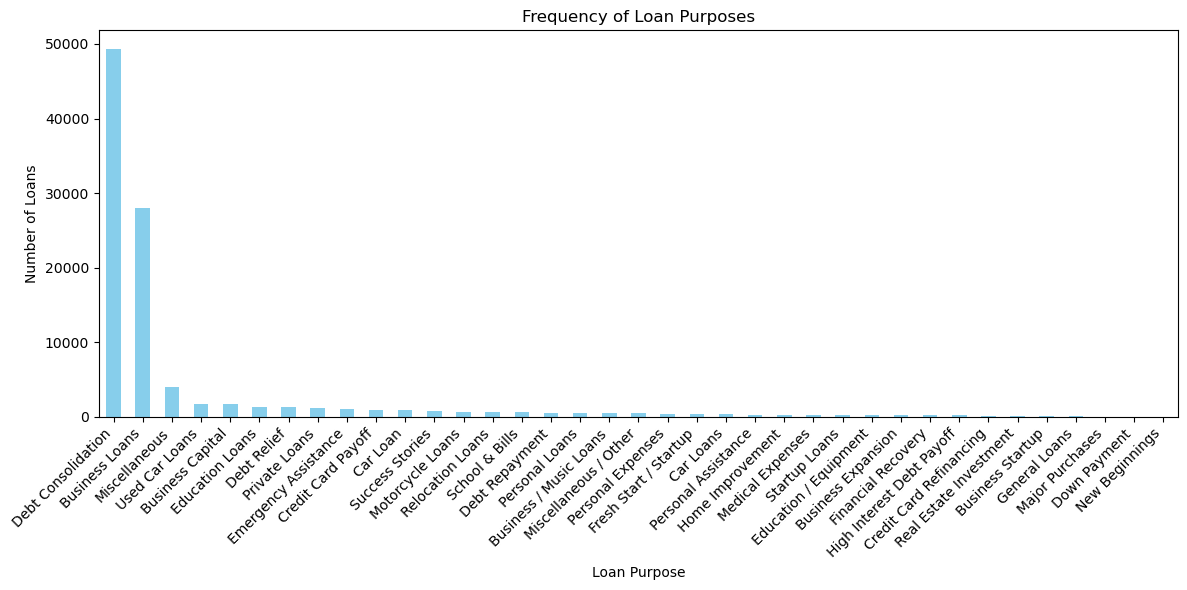

In [39]:
import matplotlib.pyplot as plt

# Count frequency of each loan purpose
loan_counts = df_combined['loan_purpose'].value_counts()

# Plot histogram / bar chart
plt.figure(figsize=(12,6))
loan_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Loan Purposes')
plt.xlabel('Loan Purpose')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


This is how I converted 30,000~ categories into 50 using OpenAI API calls. Text processing has nver been easier!

# Step 3: Feature Engineering

In [42]:
import pandas as pd

# Create special-case flags
df_combined['high_dti_flag'] = (df_combined['dti'] > 30).astype(int)
df_combined['long_term_employment'] = (df_combined['emp_length'] >= 10).astype(int)

# Create interaction feature
df_combined['loan_dti_interaction'] = df_combined['loan_amnt'] * df_combined['dti']

# Optional: check
print(df_combined.head())


   accepted addr_state    dti  emp_length issue_d  loan_amnt  \
0         1         PA   5.91        10.0       0     3600.0   
1         1         SD  16.06        10.0       0    24700.0   
2         1         IL  10.78        10.0       0    20000.0   
3         1         NJ  17.06        10.0       0    35000.0   
4         1         PA  25.37         3.0       0    10400.0   

         loan_purpose  high_dti_flag  long_term_employment  \
0  Debt Consolidation              0                     1   
1      Used Car Loans              0                     1   
2  Debt Consolidation              0                     1   
3  Debt Consolidation              0                     1   
4    Business Capital              0                     0   

   loan_dti_interaction  
0               21276.0  
1              396682.0  
2              215600.0  
3              597100.0  
4              263848.0  


In [43]:
print(df_combined.head())

   accepted addr_state    dti  emp_length issue_d  loan_amnt  \
0         1         PA   5.91        10.0       0     3600.0   
1         1         SD  16.06        10.0       0    24700.0   
2         1         IL  10.78        10.0       0    20000.0   
3         1         NJ  17.06        10.0       0    35000.0   
4         1         PA  25.37         3.0       0    10400.0   

         loan_purpose  high_dti_flag  long_term_employment  \
0  Debt Consolidation              0                     1   
1      Used Car Loans              0                     1   
2  Debt Consolidation              0                     1   
3  Debt Consolidation              0                     1   
4    Business Capital              0                     0   

   loan_dti_interaction  
0               21276.0  
1              396682.0  
2              215600.0  
3              597100.0  
4              263848.0  


# Step 4: Data Preprocessing
##  4.1 Encoding

In [45]:
import pandas as pd

# 1. Encode categorical columns using one-hot encoding
df_combined_encoded = pd.get_dummies(df_combined, columns=['addr_state','loan_purpose'], drop_first=True)

# 2. Fill NaNs in any boolean columns and convert them to int
bool_cols = df_combined_encoded.select_dtypes(include='bool').columns
df_combined_encoded[bool_cols] = df_combined_encoded[bool_cols].fillna(0).astype(int)

# Display the first few rows
print(df_combined_encoded.head(3))


   accepted    dti  emp_length issue_d  loan_amnt  high_dti_flag  \
0         1   5.91        10.0       0     3600.0              0   
1         1  16.06        10.0       0    24700.0              0   
2         1  10.78        10.0       0    20000.0              0   

   long_term_employment  loan_dti_interaction  addr_state_AL  addr_state_AR  \
0                     1               21276.0              0              0   
1                     1              396682.0              0              0   
2                     1              215600.0              0              0   

   ...  loan_purpose_Personal Assistance  loan_purpose_Personal Expenses  \
0  ...                                 0                               0   
1  ...                                 0                               0   
2  ...                                 0                               0   

   loan_purpose_Personal Loans  loan_purpose_Private Loans  \
0                            0             

## 4.2 Normalize

In [47]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Make a copy of the encoded dataframe
df_combined_normalized = df_combined_encoded.copy()

# Columns to normalize
numerical_cols_df_combined = ['loan_amnt', 'dti', 'loan_dti_interaction']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the numeric columns
df_combined_normalized[numerical_cols_df_combined] = scaler.fit_transform(
    df_combined_normalized[numerical_cols_df_combined]
)

# Display first few rows
print(df_combined_normalized.head())


   accepted       dti  emp_length issue_d  loan_amnt  high_dti_flag  \
0         1  0.000002        10.0       0   0.078481              0   
1         1  0.000005        10.0       0   0.612658              0   
2         1  0.000003        10.0       0   0.493671              0   
3         1  0.000005        10.0       0   0.873418              0   
4         1  0.000007         3.0       0   0.250633              0   

   long_term_employment  loan_dti_interaction  addr_state_AL  addr_state_AR  \
0                     1              0.000001              0              0   
1                     1              0.000010              0              0   
2                     1              0.000006              0              0   
3                     1              0.000015              0              0   
4                     0              0.000007              0              0   

   ...  loan_purpose_Personal Assistance  loan_purpose_Personal Expenses  \
0  ...                

In [48]:
df_combined_normalized= df_combined_normalized.drop(columns=['issue_d'])

In [49]:
# Number of rows before dropping
rows_before = df_combined_normalized.shape[0]

# Drop rows with any missing values
df_combined_normalized = df_combined_normalized.dropna()

# Number of rows after dropping
rows_after = df_combined_normalized.shape[0]

print(f"Rows before dropping missing values: {rows_before}")
print(f"Rows after dropping missing values: {rows_after}")


Rows before dropping missing values: 99968
Rows after dropping missing values: 99967


# Step 4: Model Training
## 4.1 Train/Test Split

In [51]:
from sklearn.model_selection import train_test_split

X = df_combined_normalized.drop(columns=['accepted'])
y = df_combined_normalized['accepted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


## 4.2 Train Models


In [53]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## 4.2.1 Logistic Regression

In [55]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

lr_grid = GridSearchCV(lr, lr_params, scoring='roc_auc', cv=5, n_jobs=-1)
lr_grid.fit(X_train, y_train)
y_pred_lr = lr_grid.predict_proba(X_test)[:,1]
print("Logistic Regression best params:", lr_grid.best_params_)
print("Logistic Regression AUC:", roc_auc_score(y_test, y_pred_lr))

Logistic Regression best params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression AUC: 0.9448472383430058


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score

# Best model: replace with your trained model
model = LogisticRegression(max_iter=1000,C= 10, penalty =  'l2', solver= 'lbfgs', random_state=42)
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = (y_pred_prob >= 0.5).astype(int)




In [59]:
# --------------------------
# 1. Metrics
# --------------------------
roc_auc = auc(*roc_curve(y_test, y_pred_prob)[:2])
f1 = f1_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.3f}")
print(f"F1-score: {f1:.3f}")


ROC-AUC: 0.945
F1-score: 0.896


In [61]:
# --------------------------
# 2. Profit Curve
# --------------------------
profit_per_good_loan = 1000
loss_per_default = -5000

# Sort by predicted probability descending
sorted_idx = np.argsort(y_pred_prob)[::-1]
y_test_sorted = y_test.iloc[sorted_idx].values
y_pred_prob_sorted = y_pred_prob[sorted_idx]

# Cumulative expected profit
expected_profit = np.cumsum(
    y_test_sorted * profit_per_good_loan + (1 - y_test_sorted) * loss_per_default
)


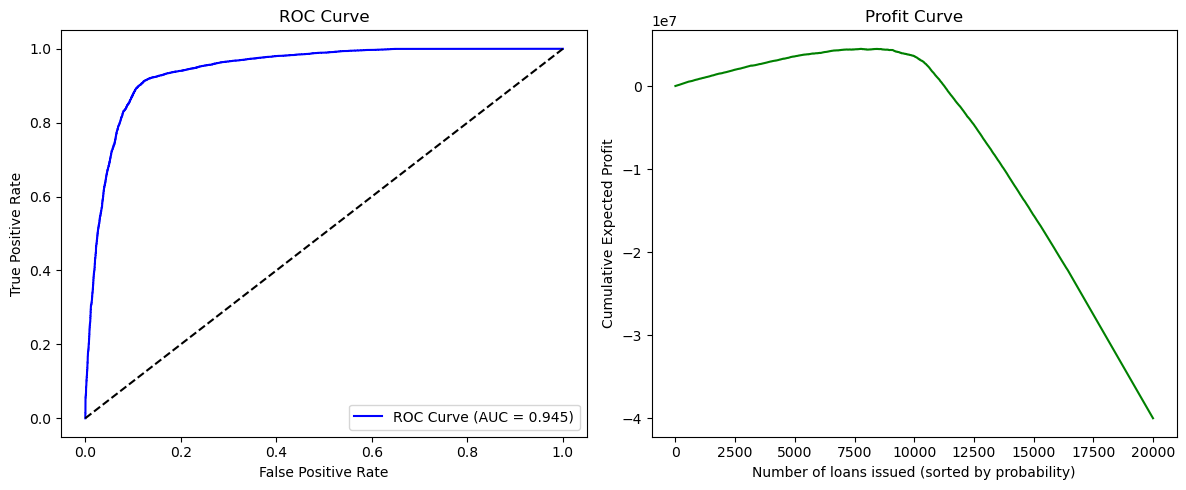

In [63]:
# --------------------------
# 3. ROC Curve
# --------------------------
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(12,5))

# ROC Curve
plt.subplot(1,2,1)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_val:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Profit Curve
plt.subplot(1,2,2)
plt.plot(np.arange(len(expected_profit)), expected_profit, color='green')
plt.xlabel('Number of loans issued (sorted by probability)')
plt.ylabel('Cumulative Expected Profit')
plt.title('Profit Curve')

plt.tight_layout()
plt.show()

## 4.2.2 XGBoost

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

def expected_profit(y_true, y_pred_prob, threshold=0.5, profit_tp=1000, cost_fp=500):

    y_pred = (y_pred_prob >= threshold).astype(int)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp * profit_tp - fp * cost_fp

def profit_curve(y_true, y_pred_prob, profit_tp=1000, cost_fp=500):
    thresholds = np.linspace(0, 1, 100)
    profits = [expected_profit(y_true, y_pred_prob, t, profit_tp, cost_fp) for t in thresholds]
    return thresholds, profits

# ---------- Random Forest ----------
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}
rf_cv = RandomizedSearchCV(rf, rf_params, cv=5, scoring='roc_auc', n_iter=10, n_jobs=-1, random_state=42)
rf_cv.fit(X_train, y_train)

best_rf = rf_cv.best_estimator_
rf_probs = best_rf.predict_proba(X_test)[:,1]
rf_auc = roc_auc_score(y_test, rf_probs)
rf_f1 = f1_score(y_test, (rf_probs >= 0.5).astype(int))
rf_profit = expected_profit(y_test, rf_probs)

print("Random Forest Best Params:", rf_cv.best_params_)
print("RF AUC:", rf_auc)
print("RF F1:", rf_f1)
print("RF Expected Profit:", rf_profit)

## 4.2.3 Random Forest

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# ---------- Custom Expected Profit Metric ----------
def expected_profit(y_true, y_pred_prob, threshold=0.5, profit_tp=1000, cost_fp=500):
    """
    profit_tp: profit if loan is repaid (True Positive)
    cost_fp: loss if defaulted loan is accepted (False Positive)
    """
    y_pred = (y_pred_prob >= threshold).astype(int)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp * profit_tp - fp * cost_fp

def profit_curve(y_true, y_pred_prob, profit_tp=1000, cost_fp=500):
    thresholds = np.linspace(0, 1, 100)
    profits = [expected_profit(y_true, y_pred_prob, t, profit_tp, cost_fp) for t in thresholds]
    return thresholds, profits

# ---------- Random Forest ----------
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}
rf_cv = RandomizedSearchCV(rf, rf_params, cv=5, scoring='roc_auc', n_iter=10, n_jobs=-1, random_state=42)
rf_cv.fit(X_train, y_train)

best_rf = rf_cv.best_estimator_
rf_probs = best_rf.predict_proba(X_test)[:,1]
rf_auc = roc_auc_score(y_test, rf_probs)
rf_f1 = f1_score(y_test, (rf_probs >= 0.5).astype(int))
rf_profit = expected_profit(y_test, rf_probs)

print("Random Forest Best Params:", rf_cv.best_params_)
print("RF AUC:", rf_auc)
print("RF F1:", rf_f1)
print("RF Expected Profit:", rf_profit)